# Another slow unstructured mesh program - dataframes

Spark's graph-parallel package, [GraphX](http://spark.apache.org/graphx/), enables very efficient computations on graphs like unstructured meshes.

Unfortunately some of the coolest features won't be accessible through python until Spark 2.x, but we can give an idea how it works now, quite slowly, using dataframes, which involve less conversions:

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import findspark

findspark.init()
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
sc = SparkContext("local[2]")
sqlc = SQLContext(sc)

We will need global information about our mesh here, and in Spark that means "broadcast variables" (think global constants across processes).  We'll make a tuple a global constant and define some functions as easy ways to get at them:

In [3]:
# Routines for broadcasting a geometry as a tuple and getting facts back about it.

npts_x = 11
npts_y = 11
npts = npts_x * npts_y
dx_val = 1./(npts_x-1)
dy_val = 1./(npts_y-1)

mesh = [npts_x, npts_y, npts, dx_val, dy_val]

mesh = sc.broadcast(mesh)

def npts():
    return mesh.value[2]

def npts_x():
    return mesh.value[0]

def npts_y():
    return mesh.value[1]

def dx():
    return mesh.value[3]

def dy():
    return mesh.value[4]

We'll have a 1-d list of points, indiciated by indicies, and below are some routines to look up the point positions and the neighbours by indicies.  Note that what we have below actually sets up a structured (if irregular) triangular mesh, but nothing below assumes anything about the structure of the mesh (even that it's static).

In [4]:
# Routines setting up an (actually structured) triangle connectivity

def idx_to_grid(idx):
    return (idx % npts_x(), idx//npts_x())

def grid_to_idx(i, j):
    return j*npts_x()+i

def valid_point(i, j):
    return i>= 0 and i < npts_x() and j >= 0 and j < npts_y()

def interior_point(i,j):
    return i> 0 and i < npts_x()-1 and j > 0 and j < npts_y()-1

def interior_idx(self, idx):
    return interior_point(*idx_to_grid(idx))

def idx_to_x(idx):
    return idx_to_grid(idx)[0]*dx()
 
def idx_to_y(idx):
    return idx_to_grid(idx)[1]*dy()
    
def neighbours_of(idx):
    deltas = [-1, 0, 1]
    i, j = idx_to_grid(idx)
    all_neighs = [(i+di,j+dj) for di in deltas for dj in deltas if not (di == 0 and dj == 0)]
    return [grid_to_idx(*neighbour) for neighbour in all_neighs if valid_point(*neighbour)]

Ok, now we are ready to go.  We'll define an initial condition - a guassian blob of density at a given position and with a given size.  The function below returns that value (along with the x and y positions) at a given index

In [5]:
def initial_conditions(idx, initial_posx=0.3, initial_posy=0.3, sigma=0.15):
    """Returns a tuple describing the state at the point:
        (x, y, density(x,y))"""
    x = idx_to_x(idx) + np.random.rand()/(3*npts_x())
    y = idx_to_y(idx) + np.random.rand()/(3*npts_y())
    density = np.exp(-((x-initial_posx)**2 + (y-initial_posy)**2)/(sigma**2))
    return [idx, x, y, float(density)]

And now we're going to set up the main data structures - split-up RDDs of the values (with an index, and a tuple of (x, y, density), and the edge list - eg, that index 0 is connected to 20 and vice versa.

In [6]:
values_df = sqlc.createDataFrame( sc.parallelize(range(npts())).map(lambda idx:initial_conditions(idx)),
                                  ["id", "x", "y", "density"] )
neighbours_df = sqlc.createDataFrame(sc.parallelize(range(npts()))\
                                     .flatMap(lambda idx:[(idx, neigh) for neigh in neighbours_of(idx)]),
                                      ["src", "dest"])

These data frames look (intentionally) like R or pandas dataframes, except (as with RDDs) they are immutable:

In [7]:
values_df.show()

+---+--------------------+--------------------+--------------------+
| id|                   x|                   y|             density|
+---+--------------------+--------------------+--------------------+
|  0|0.002230627562632...| 0.01812630562914728|5.688052847624568E-4|
|  1|  0.1253704441651885|0.023822468664908402|0.008692353206719822|
|  2| 0.21671328795020278|0.009891695152522868|0.017442127356869584|
|  3| 0.32232721117169205|0.011610295661243497|0.024269401245647037|
|  4| 0.41978463685320083|0.013534724456444651|0.013774715301500916|
|  5|   0.500611247506803| 0.01616393743505034|0.004657694006486126|
|  6|  0.6120116316756002|0.003930392857542483|2.685163660628643E-4|
|  7|  0.7275193619884861|0.014720224987610369|7.966009467489214E-6|
|  8|  0.8240887361199677|0.021525003866123542|1.590410625057572E-7|
|  9|   0.919099262096205|0.007147300598307079|8.840428779519995...|
| 10|  1.0300356604880647|0.020392665626747554|1.599329309022676...|
| 11|0.023773852105224053| 0.12962

Let's see what we've got now - here's a routine which collects all the data to the main process and graphs it:

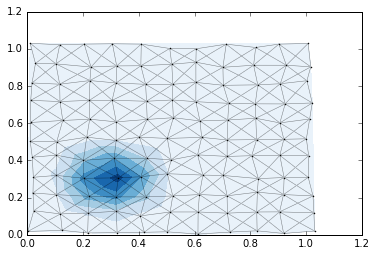

In [8]:
def show_results_df(field, neighbours):
    allvalues = sorted(field.collect())
    allneighbourpairs = neighbours.collect()

    xs, ys, value = zip(*[(values.x, values.y, values.density) for values in allvalues])
    plt.tricontourf(xs, ys, value, cmap=plt.cm.Blues)
    plt.plot(xs, ys, 'ko', markersize=1)
    
    gridline_xs = [xvalue for idx, nbr in allneighbourpairs
                          for xvalue in (xs[idx], xs[nbr], None)]
    gridline_ys = [yvalue for idx, nbr in allneighbourpairs
                          for yvalue in (ys[idx], ys[nbr], None)]
    plt.plot(gridline_xs, gridline_ys, 'k-', linewidth=.5, alpha=0.25)
    
show_results_df(values_df, neighbours_df)     

Lovely!  Now, we'll set up a simple constant-velocity advection on this field.  To do that, we need some way of calculating the gradient at each point.  (Students, look away - this is a kind of crummy way of solving an advection equation.  I'm not even upwinding!  But this gradient calculation is quite general and would work with moving points. 

In [ ]:
v = sc.broadcast(np.array([0.1, 0.1]))
speed = np.sqrt(v.value[0]**2 + v.value[1]**2)
cfl = 0.25

dt = sc.broadcast(cfl*dx()/speed)

def grad_y(row):
    num = row["sum(dy_ddens)"]-row["sum(dx_ddens)"]*row["sum(dx_dy)"]/row["sum(dx_sq)"]
    denom = row["sum(dy_sq)"] - row["sum(dx_dy)"]**2/row["sum(dx_sq)"]
    return num/denom

def grad_x(row):
    num = row["sum(dy_ddens)"]-row["sum(dx_ddens)"]*row["sum(dx_dy)"]/row["sum(dx_sq)"]
    denom = row["sum(dy_sq)"] - row["sum(dx_dy)"]**2/row["sum(dx_sq)"]
    grady = num/denom
    gradx = (row["sum(dx_ddens)"]-row["sum(dx_dy)"]*grady)/row["sum(dx_sq)"]
    return gradx

def update_density(val, grad):
    old_dens = val["density"]
    new_dens = old_dens + dt.value*(grad["grad_x"]*v.value[0] + grad["grad_y"]*v.value[1])
    return new_dens

def dataframe_update_values(values_df, neighbours_df):
    neighbour_values = values_df.join(neighbours_df, values_df.id == neighbours_df.src)\
                        .select("dest","x","y","density")
    newvalues = values_df.select(values_df.id, values_df.x.alias("xo"), 
                                 values_df.y.alias("yo"), values_df.density.alias("denso"))\
               .join(neighbour_values, values_df.id == neighbour_values.dest)
    deltas = newvalues.select(newvalues.id, (newvalues.x-newvalues.xo).alias("dx"), 
                              (newvalues.y-newvalues.yo).alias("dy"),
                              (newvalues.density-newvalues.denso).alias("ddens"))
    terms = deltas.select(deltas.id, (deltas.dx*deltas.dx).alias("dx_sq"), (deltas.dy*deltas.dy).alias("dy_sq"),
                      (deltas.dx*deltas.dy).alias("dx_dy"),
                      (deltas.dx*deltas.ddens).alias("dx_ddens"), (deltas.dy*deltas.ddens).alias("dy_ddens"))
    collect_terms = terms.groupBy("id").sum()

    gradients = collect_terms.select(collect_terms.id,  grad_y(collect_terms).alias("grad_y"), grad_x(collect_terms).alias("grad_x"))
    
    updated_values = values_df.join(gradients)\
                        .select(values_df.id, values_df.x, values_df.y, update_density(values_df, gradients).alias("density"))

    return updated_values

Let's run!  (slowly)

Note that the `run_n_steps` bit just sets up the computation; it's the showing of results (which collects all the data) which is an action, so starts things in motion.

In [ ]:
values_df = dataframe_update_values(values_df, neighbours_df)
show_results_df(values_df, neighbours_df)  

In [ ]:
values_df = dataframe_update_values(values_df, neighbours_df)
show_results_df(values_df, neighbours_df) 

In [ ]:
sc.stop()